## Load ground truth

In [1]:
import pandas as pd
import json
topics_file_path = 'output/llm_output/topics.json'
with open(topics_file_path, 'r') as f:
    topics = json.load(f)
ground_truth = [dict(topic_name = x['topic_name'], 
                     ts_msg_id = x['msg_ids'][0],
                     question = x['question'],
                     answer = x['answer'],
                     ) for x in topics]
ground_truth[0]




{'topic_name': 'Медицинский чекап и очереди',
 'ts_msg_id': 186659,
 'question': 'What is the best time to go for a medical checkup to avoid long queues?',
 'answer': 'Going after lunch might be advisable as it seems there are generally fewer people, and the process is quicker.'}

### gettind data from summarization by topics, where we already have question and answer, that can be used as ground truth data

In [1]:
topics_file_path = 'output/llm_output/topics.json'
topics_file_path_gt = 'output/llm_output/ground_truth.json'

In [4]:
from tqdm.auto import tqdm
import json
import src.config as cfg
from src.rag_integration import RaguDuDu
llm_models = [("gpt4o", "gpt-4o-2024-08-06", (2.5, 10)),
              ("gpt4o_mini", "gpt-4o-mini", (0.15, 0.6))] # input,output tokens, usd for 1M

rg = RaguDuDu()
with open(topics_file_path, 'r') as f:
    topics = json.load(f)
ground_truth = [dict(topic_name=x['topic_name'],
                        ts_msg_id=x['msg_ids'][0],
                        question=x['question'],
                        answer=x['answer'],
                    ) for x in topics]
for topic in tqdm(ground_truth):
    question = topic['question']
    for llm_model_key, llm_model, llm_price in llm_models:
        cfg.llm_model, cfg.llm_price = llm_model, llm_price
        rg.llm_model=llm_model # looks bit weird..
        rag_answer = rg.rag_by_dense_vector_search(question=question)
        topic[f"rag_answer_{llm_model_key}"] = rag_answer['answer']
        topic[f"msg_ids_{llm_model_key}"] = rag_answer['msg_ids']
    with open(topics_file_path_gt, 'w') as fl:
        json.dump(ground_truth, fl, ensure_ascii=False, indent=4)


Creating the messages    index...


8746it [00:00, 91494.13it/s]
8746it [00:00, 89821.31it/s]
  0%|          | 0/51 [00:00<?, ?it/s]/Users/dklmn/.local/share/virtualenvs/telegram_rag_search-oI0nq4RM/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/dklmn/.local/share/virtualenvs/telegram_rag_search-oI0nq4RM/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-

## Cosine similarity


### gpt-4o vs gpt-4o mini

In [11]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/Users/dklmn/.local/share/virtualenvs/telegram_rag_search-oI0nq4RM/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
def compute_similarities(record, models):
    answer_orig = record['answer']

    v_orig = model.encode(answer_orig)
    sims = {}
    for m in models:
        rag_answer = record[f'rag_answer_{m}']
        v_llm = model.encode(rag_answer)
        sims[m] = v_llm.dot(v_orig)    
    return sims

In [14]:
with open(topics_file_path_gt, 'r') as f:
    dd = json.load(f)
similarity = []
mm  = [model_key for model_key, _, _ in llm_models]
for d in tqdm(dd):
    sims = compute_similarities(d, mm)
    for m in mm:
        d[f'sim_{m}'] = sims[m]


100%|██████████| 51/51 [00:03<00:00, 13.00it/s]


In [15]:
import pandas as pd
df = pd.DataFrame(dd)
df

,topic_name,ts_msg_id,question,answer,rag_answer_gpt4o,msg_ids_gpt4o,rag_answer_gpt4o_mini,msg_ids_gpt4o_mini,sim_gpt4o,sim_gpt4o_mini
0,Медицинский чекап и очереди,186659,What is the best time to go for a medical chec...,Going after lunch might be advisable as it see...,The best time to go for a medical checkup to a...,"[186659, 187949, 187950, 187953]","To avoid long queues for medical checkups, it'...","[187949, 187950, 187953]",0.401512,0.443652
1,Продление ВНЖ и роль страхования SGK,188347,Is SGK insurance mandatory for the renewal of ...,SGK is not mandatory for the renewal of a resi...,SGK insurance is not mandatory for the renewal...,"[188358, 188408, 188410, 188411]",SGK insurance is not mandatory for the renewal...,"[188358, 188374, 188411]",0.960499,0.917473
2,Проблемы транспорта и работа в офисе,192255,What are the challenges of commuting to the of...,The challenges include high vehicle costs and ...,Commuting to the office from Antalya seems to ...,"[186135, 186138, 186139, 192230, 192231, 19224...",Commuting in Antalya can be challenging due to...,"[186135, 186138, 192231]",0.514389,0.482955
3,Прописка иностранцев в арендуемом жилье,183632,Is it possible to register a non-relative fore...,It is generally difficult to register non-rela...,Registering a non-relative foreigner in rented...,"[183632, 183633, 183635, 183636, 183637, 18363...",It seems that registering a non-relative forei...,"[183632, 183633, 183638, 183640]",0.834849,0.865584
4,Бюрократия и получение справки о несудимости,183784,What can be done when strange requirements com...,Participants suggest asking to see the law on ...,When faced with strange requirements complicat...,"[191579, 191593, 191594, 191595, 191596, 19159...",When facing strange requirements while obtaini...,"[191579, 191593, 191596, 191605, 191727]",0.248374,0.206865
5,Романтические поездки и фото в Каппадокии,184130,What is the best time for a romantic photo ses...,The best time for a romantic photo session in ...,The best time for a romantic photo session in ...,"[184134, 184154]",For the best romantic photo session in Cappado...,"[184134, 184154]",0.922792,0.898855
6,Обсуждение переездов и жизни в Турции,185322,What are the challenges people face when reloc...,"Challenges include rising taxes, high costs, l...",Relocating to Turkey involves several challeng...,"[187096, 187101, 187252, 187257, 186046, 186035]",People relocating to Turkey face several chall...,"[187096, 187097, 187252, 187256]",0.719960,0.830474
7,Поиски квартир в Анталии,186146,Where might available apartments be listed out...,Apartments might be listed with individual age...,"Apartments might also be found on Facebook, pa...","[186509, 186512, 186514, 186519, 186535, 186596]",Apartments can be found listed on platforms ot...,"[186146, 186510, 186514, 186515, 186519]",0.749199,0.798665
8,Такси и маршруты в Анталии,188528,How does the taxi fare calculation in Antalya ...,The taxi fare in Antalya is calculated based o...,The taxi fare in Antalya seems to depend on th...,"[187345, 187347, 187348, 187358]","In Antalya, the taxi fare is calculated based ...","[187345, 187358]",0.724736,0.891886
9,"цены, блокировки и перспективы переезда",185092,What are the current issues people face in Tur...,Current issues in Turkey include rising prices...,"In Turkey, the primary concerns prompting relo...","[190547, 190548, 190550, 190551, 190552, 18725...",People are currently facing several issues in ...,"[187094, 187096, 187100, 187101, 187252, 187257]",0.789175,0.863168


In [18]:


columns_to_describe = ['sim_gpt4o', 'sim_gpt4o_mini']

df_sim_descr = pd.concat([df[col].describe() for col in columns_to_describe], axis=1)
df_sim_descr.columns = columns_to_describe
df_sim_descr

,sim_gpt4o,sim_gpt4o_mini
count,51.000000,51.000000
mean,0.624657,0.728666
std,0.296105,0.190095
min,-0.057634,0.157326
25%,0.544563,0.655950
50%,0.721764,0.789234
75%,0.830972,0.865296
max,0.960499,0.939044


### discussion
Hm.. looks like RAG results for gpt-4o mini is close ro ground truth data, that are created by 4o, compared to RAG results for 4o..


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/folders/_s/0tpy0fpj29nd

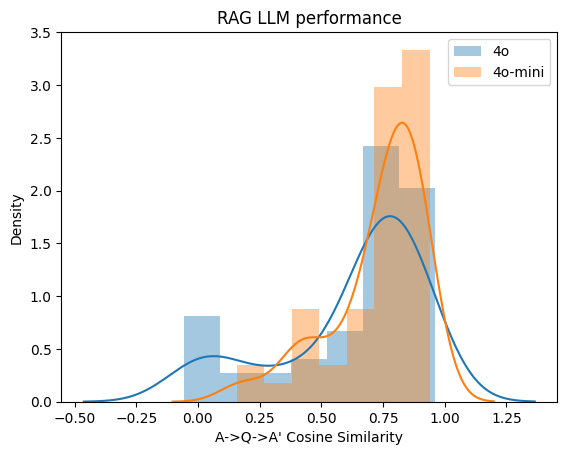

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['sim_gpt4o'], label='4o')
sns.distplot(df['sim_gpt4o_mini'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

In [ ]:
## TODO - calculation of MMR and Hit Rate for search

In [16]:
### save results to csv
df.to_csv('output/llm_output/ground_truth.csv',index=False)